# Imports 

In [2]:
import numpy as np
from scripts import data_loading
from scripts.models import CrfFeatures

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline

In [34]:
from sklearn.model_selection import cross_val_predict, cross_val_score

In [ ]:
import eli5

In [ ]:
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

#### Parameters and constants 

In [4]:
PATH = r'C:\Users\Ruslan_Golubev\Documents\laba-task3-toxic-comments\NER - GMB\gmb-2.2.0\data'
tags_file_name = '\en.tags'
source_file_name = '\en.met'
columns = ['raw', 'pos', 'lemma', 'ner_target', 'word_net_pos', 'animacy_tag', 'title', 'date', 'genre', 'n_sent']
SEED = 77

# Data loading

In [5]:
data = data_loading.many_folders(PATH, source_file_name, tags_file_name, columns)

10000it [00:04, 2257.96it/s]


In [6]:
data['ner_target'] = data['ner_target'].apply(lambda x: x.split('-')[0])
tags_df = data[['raw', 'pos', 'lemma', 'ner_target', 'title', 'n_sent']]

In [7]:
tags_df.head()

,raw,pos,lemma,ner_target,title,n_sent
0,Thousands,NNS,thousand,O,Thousands Protest Iraq War in London,0
1,of,IN,of,O,Thousands Protest Iraq War in London,0
2,demonstrators,NNS,demonstrator,O,Thousands Protest Iraq War in London,0
3,have,VBP,have,O,Thousands Protest Iraq War in London,0
4,marched,VBN,march,O,Thousands Protest Iraq War in London,0


In [8]:
tags_df.shape

(1231279, 6)

# EDA

In [9]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231279 entries, 0 to 1231278
Data columns (total 6 columns):
raw           1231279 non-null object
pos           1231279 non-null object
lemma         1231279 non-null object
ner_target    1231279 non-null object
title         1231279 non-null object
n_sent        1231279 non-null int64
dtypes: int64(1), object(5)
memory usage: 56.4+ MB


In [10]:
sents = data_loading.get_sent(tags_df)

In [11]:
words = list(set(tags_df["raw"].values))
n_words = len(words)
print(n_words)

35153


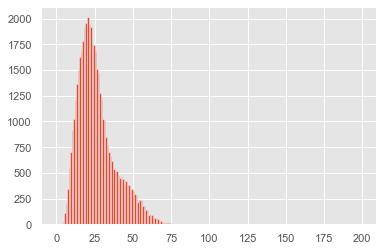

In [12]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sents], bins=[i for i in range(200)])
plt.show()

In [13]:
maxlen = max([len(s) for s in sents])
print ('Maximum sent length:', maxlen)

Maximum sent length: 92


In [14]:
sents[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [15]:
for tag in tags_df.ner_target.unique():
    print('Words with tag', tag,'\n', tags_df.loc[tags_df['ner_target'] == tag, 'raw'].head())

Words with tag O 
 0        Thousands
1               of
2    demonstrators
3             have
4          marched
Name: raw, dtype: object
Words with tag geo 
 6      London
12       Iraq
65       Hyde
66       Park
94    Britain
Name: raw, dtype: object
Words with tag gpe 
 18     British
102    English
113    Britain
126    British
173       Iran
Name: raw, dtype: object
Words with tag per 
 42            Bush
270      President
271        Mahmoud
272    Ahmadinejad
331         Thomas
Name: raw, dtype: object
Words with tag org 
 97             Labor
98             Party
154    International
155           Atomic
156           Energy
Name: raw, dtype: object
Words with tag tim 
 167    Wednesday
211    Wednesday
274      Tuesday
341    Wednesday
493    Wednesday
Name: raw, dtype: object
Words with tag art 
 263               Nuclear
264     Non-Proliferation
3769             Saltillo
3810            Pentastar
3811                  V-6
Name: raw, dtype: object
Words with tag nat 
 2723

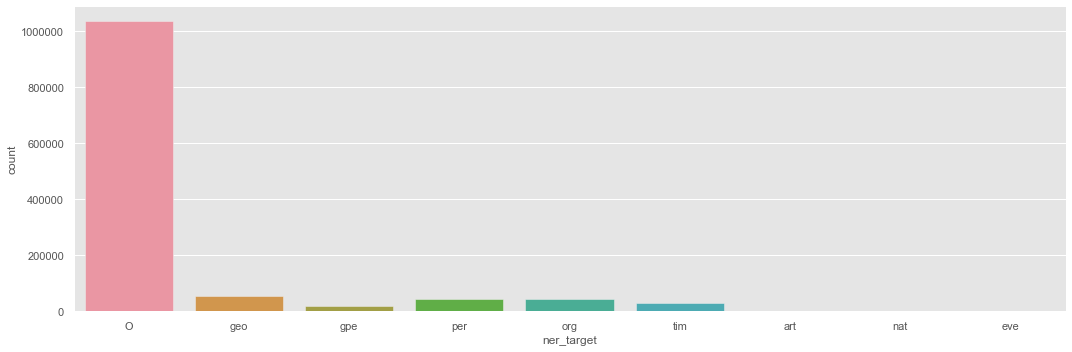

In [16]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('ner_target', data=tags_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

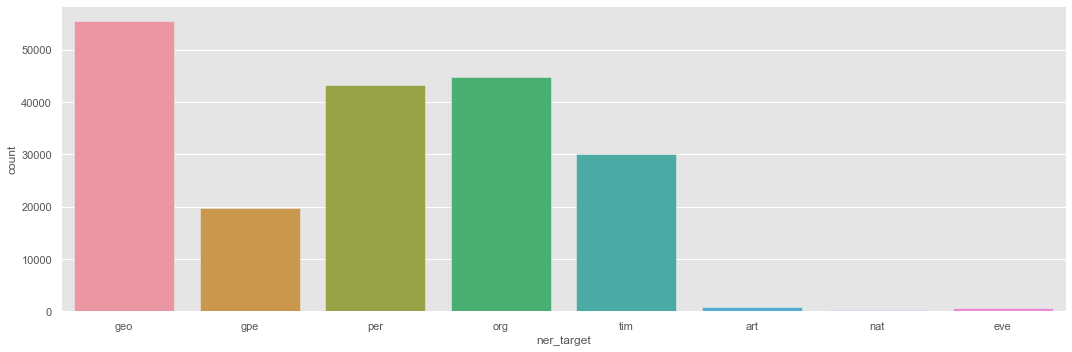

In [17]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('ner_target', data=tags_df.loc[data['ner_target'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

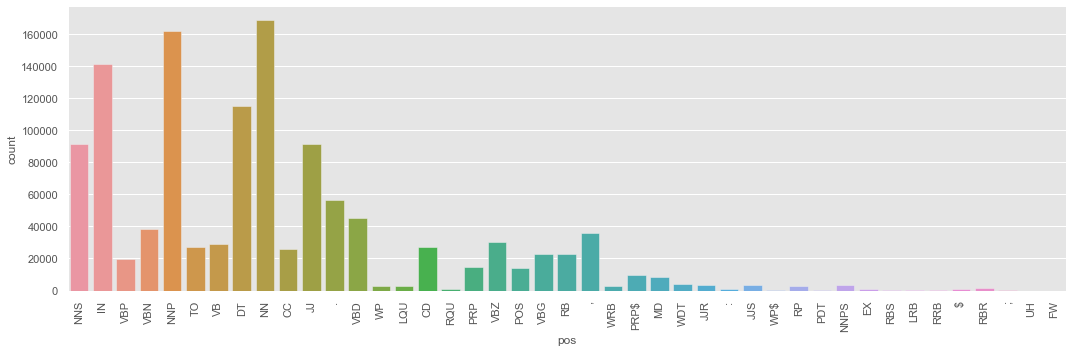

In [18]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos', data=tags_df, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# CRF

In [19]:
bio_sents = []
for i in sents:
    bio_sents.append(data_loading.bio_tags(i))

In [20]:
sents[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [21]:
bio_sents[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [40]:
features = CrfFeatures()
X, y = features.run(bio_sents)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)

In [43]:
crf = CRF(algorithm='lbfgs',
         c1=0.1,
         c2=0.1,
         max_iterations=100,
         all_possible_transitions=False)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [45]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-tim',
 'B-gpe',
 'B-org',
 'B-geo',
 'B-per',
 'I-per',
 'I-org',
 'I-geo',
 'B-art',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-art',
 'I-gpe']

In [49]:
y_pred = crf.predict(X_test)
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-art      0.464     0.194     0.274        67
       I-art      0.455     0.172     0.250        58
       B-eve      0.458     0.262     0.333        42
       I-eve      0.190     0.129     0.154        31
       B-geo      0.867     0.919     0.892      6958
       I-geo      0.808     0.826     0.817      1270
       B-gpe      0.977     0.948     0.962      2918
       I-gpe      0.818     0.346     0.486        26
       B-nat      0.667     0.296     0.410        27
       I-nat      0.600     0.600     0.600         5
       B-org      0.826     0.746     0.784      3683
       I-org      0.823     0.795     0.809      2983
       B-per      0.866     0.856     0.861      3142
       I-per      0.856     0.908     0.881      3234
       B-tim      0.932     0.885     0.908      3466
       I-tim      0.838     0.763     0.799       998

   micro avg      0.869     0.859     0.864     28908
   macro avg      0.715   

In [51]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.867,1.225,0.0,1.424,0.0,2.178,0.0,1.133,0.0,1.027,0.0,1.926,0.0,4.138,0.0,2.535,0.0
B-art,-0.422,0.0,8.212,0.0,0.0,-0.113,0.0,0.0,0.0,0.0,0.0,0.935,0.0,-0.434,0.0,0.322,0.0
I-art,-1.449,0.0,7.39,0.0,0.0,-0.727,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.527,0.0,-1.194,0.0
B-eve,-0.447,0.0,0.0,0.0,8.302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.169,0.0
I-eve,-0.114,0.0,0.0,0.0,8.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.362,0.0
B-geo,0.417,0.594,0.0,0.352,0.0,0.0,7.857,0.605,0.0,0.0,0.0,0.606,0.0,0.668,0.0,2.109,0.0
I-geo,-0.361,1.331,0.0,0.0,0.0,0.0,6.686,-0.993,0.0,0.0,0.0,-0.169,0.0,1.083,0.0,1.043,0.0
B-gpe,0.638,-0.547,0.0,-0.238,0.0,0.587,0.0,0.0,8.254,0.0,0.0,1.779,0.0,1.532,0.0,0.474,0.0
I-gpe,-0.769,0.0,0.0,0.0,0.0,-0.029,0.0,0.0,5.433,0.0,0.0,0.0,0.0,0.588,0.0,0.0,0.0
B-nat,-0.517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.608,0.0,0.0,0.217,0.0,0.046,0.0


In [59]:
import scipy.stats

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [60]:
len(labels)

16

In [61]:
labels

['B-tim',
 'B-gpe',
 'B-org',
 'B-geo',
 'B-per',
 'I-per',
 'I-org',
 'I-geo',
 'B-art',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-art',
 'I-gpe']

In [63]:
tags_df.ner_target.unique()

array(['O', 'geo', 'gpe', 'per', 'org', 'tim', 'art', 'nat', 'eve'],
      dtype=object)

# Bi-lstm

In [74]:
tags = ['unk', 'O']
tags = tags + labels

In [75]:
tags

['unk',
 'O',
 'B-tim',
 'B-gpe',
 'B-org',
 'B-geo',
 'B-per',
 'I-per',
 'I-org',
 'I-geo',
 'B-art',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-art',
 'I-gpe']

In [76]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [105]:
from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load

  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 953, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\__init__.py", line 42, in <module>
    from . _api.v2 import audio
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\_api\v2\audio\__init__.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Ruslan_Golubev\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 319, in wrapped
    return f(*args, **kwargs)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 353, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\inspect.py", line 1502, in getinnerframes
    frameinfo = (tb.tb_frame,) + getframeinfo(tb, context)
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\inspect.py", line 1460, in getframeinfo
    filename = 

TypeError: can only concatenate str (not "list") to str

In [97]:
X = [[word2idx[w[0]] for w in s] for s in bio_sents]

In [88]:
X = pad_sequences(maxlen=90, sequences=X, padding="post", value=n_words - 1)

NameError: name 'pad_sequences' is not defined

In [100]:
y_idx = [[tag2idx[w[2]] for w in s] for s in bio_sents]
print(sents[0])
print(y_idx[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]
[1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]


In [104]:
!pip install --user tensorflow

  Using cached https://files.pythonhosted.org/packages/34/d5/ce8c17971067c0184c9045112b755be5461d5ce5253ef65a367e1298d7c5/tensorflow-2.1.0-cp37-cp37m-win_amd64.whl


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [106]:
!pip install tensorflow-gpu==1.10.0

  ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.10.0 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0)
ERROR: No matching distribution found for tensorflow-gpu==1.10.0


In [ ]:
!pip uninstall tensorflow

In [2]:
!pip install tensorflow==2.0.0

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _dep_map
    return self.__dep_map
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3003, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exce

In [1]:
import pandas as pd